**New Addition**

Adjust Classification threshold to 0.3 to increase the sensivity to identify positive cases.


In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score,  classification_report , confusion_matrix , roc_auc_score , precision_score , recall_score
from imblearn.over_sampling import SMOTE
import numpy as np

In [2]:
#load the data set
df = pd.read_csv('data.csv')

In [3]:
#Rename Columns
df_columns_new = ["Y"] + [f"X{i}" for i in range(1, len(df.columns))]
df.columns = df_columns_new
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


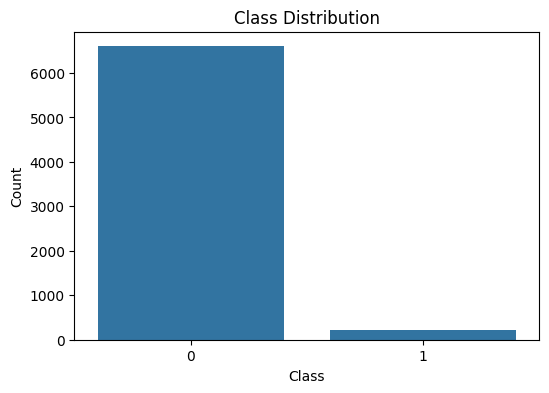

In [4]:
#Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Y', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

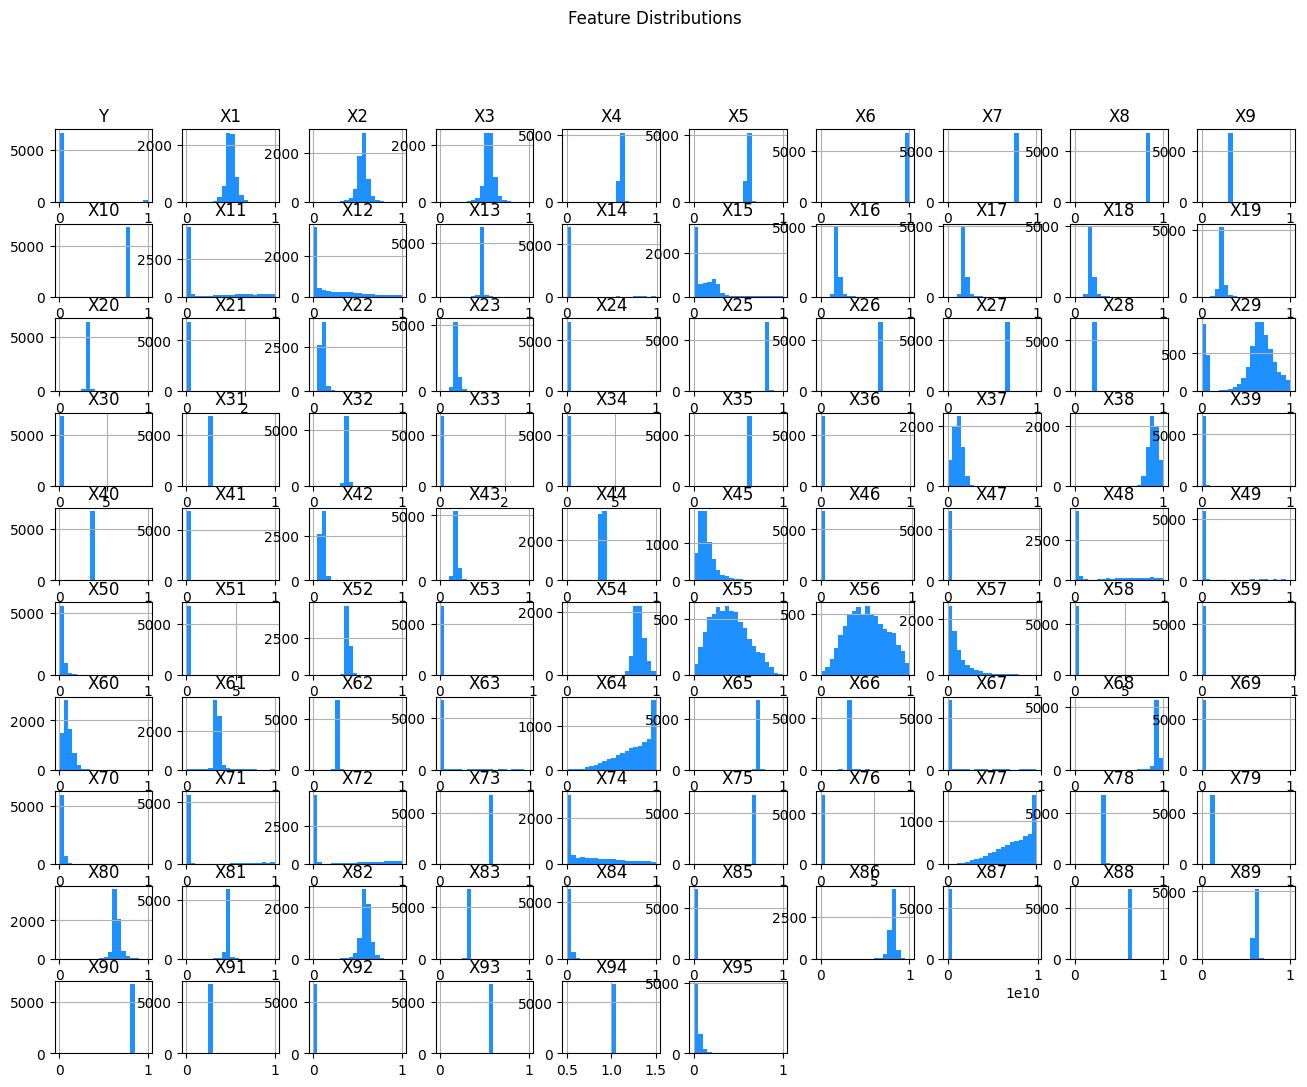

In [5]:
#Feature Distribution
df.hist(figsize=(16, 12), bins=20, color='dodgerblue')
plt.suptitle('Feature Distributions')
plt.show()

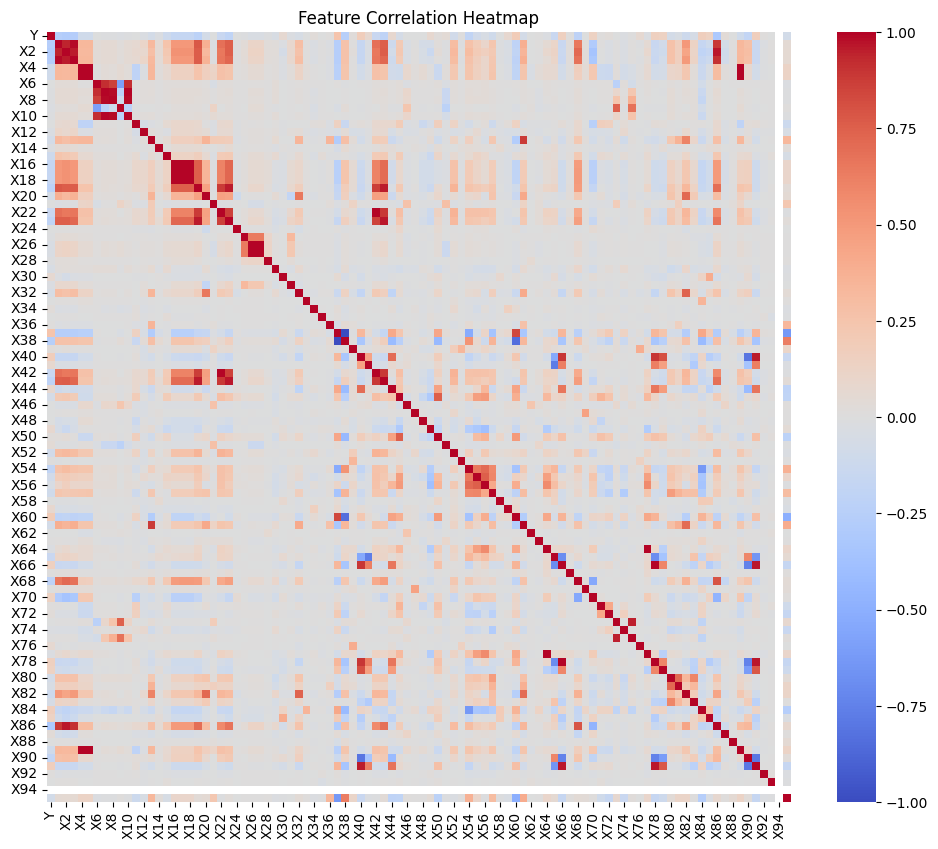

In [6]:
#Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

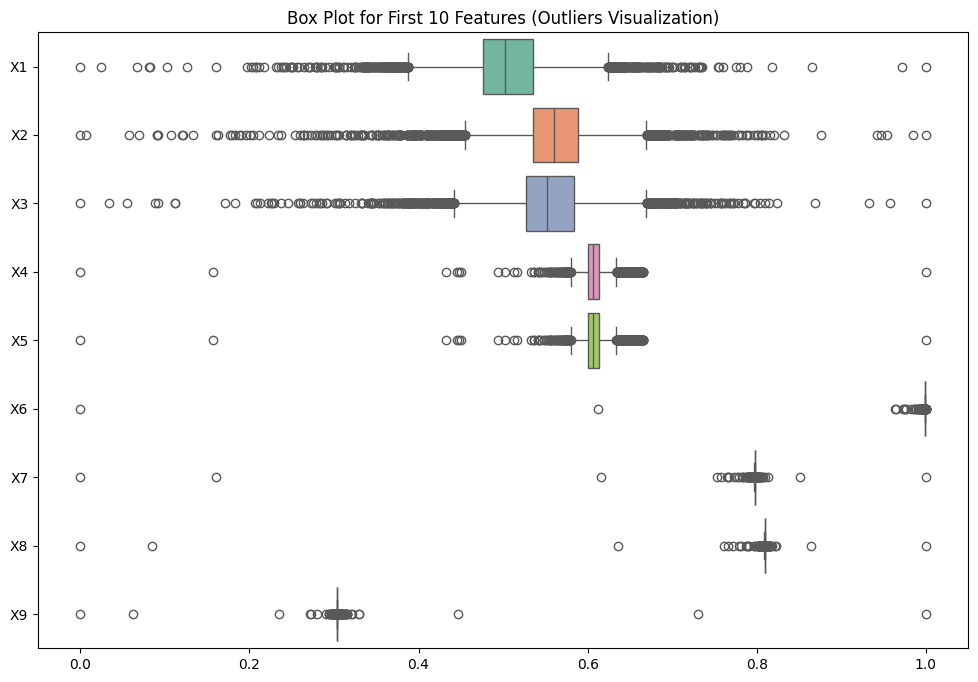

In [7]:
#Box Plot (to visualize outliers)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.iloc[:, 1:10], orient='h', palette='Set2')  #first 10 features
plt.title('Box Plot for First 10 Features (Outliers Visualization)')
plt.show()

**XGBoost has built-in preprocessing mechanisms**


*   Handling Missing Data
*   Normalization and Standardization
*   Encoding
*   Feature Scaling
*   Outlier Detection and Removal

***according to this dataset, there is no need for encoding or normalization because it does not contain any categorical data, and all numerical values already fall within the range of [0, 1].***

In [8]:
#check NaN values
print("Total NaN values:",df.isnull().sum().sum())

Total NaN values: 0


In [9]:
#check duplicates
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

Number of duplicate rows: 0


In [10]:
#check mean and standard deviation
mean_std = df[df.select_dtypes(include=[float, int]).columns.tolist()].agg(['mean', 'std'])
print("Mean and Standard Deviation:\n", mean_std)

Mean and Standard Deviation:
              Y        X1        X2        X3        X4        X5        X6  \
mean  0.032263  0.505180  0.558625  0.553589  0.607948  0.607929  0.998755   
std   0.176710  0.060686  0.065620  0.061595  0.016934  0.016916  0.013010   

            X7        X8        X9  ...       X86           X87       X88  \
mean  0.797190  0.809084  0.303623  ...  0.807760  1.862942e+07  0.623915   
std   0.012869  0.013601  0.011163  ...  0.040332  3.764501e+08  0.012290   

           X89       X90       X91       X92       X93  X94       X95  
mean  0.607946  0.840402  0.280365  0.027541  0.565358  1.0  0.047578  
std   0.016934  0.014523  0.014463  0.015668  0.013214  0.0  0.050014  

[2 rows x 96 columns]


In [11]:
#identify target variable and features
Y_label = [df.columns[0]]   #represent what we want to predict(bankrupt)
X_labels = df.columns[1:].tolist() #inputs used to make this prediction

X = df[X_labels].values
Y = df[Y_label].values

In [12]:
#check infinte values
inf_columns = df.columns[np.isinf(df).any(axis=0)]
print("Columns with infinite values:", inf_columns.tolist())

Columns with infinite values: []


In [13]:
#Dimensionality Reduction

#Variance Threshold i used to remove features with low variance
selector = VarianceThreshold(threshold=0.1)
X_reduced = selector.fit_transform(X)

#PCA to reduce dimensionality
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_reduced)

In [14]:
#Splitting the dataset into training and test sets
X_train , X_temp, y_train , y_temp = train_test_split(X_pca, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4091, 8)
Validation set shape: (1364, 8)
Test set shape: (1364, 8)


In [15]:
#scale_pos_weight for handling imbalance
scale_pos_weight = float((len(y_train) / sum(y_train))/ sum(y_train))
print("Scale pos weight:", scale_pos_weight)

#SMOTE for handling imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Resampled dataset shape:", X_resampled.shape)
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

Scale pos weight: 0.24583859143080344
Resampled dataset shape: (7924, 8)
Class distribution after SMOTE:
 0    3962
1    3962
Name: count, dtype: int64


<ipython-input-15-7eeadcfbea46>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scale_pos_weight = float((len(y_train) / sum(y_train))/ sum(y_train))


In [16]:
#Hyperparameter tuning
param_grid ={
    'n_estimators': [100, 200],
    'max_depth': [3,5,7],
    'min_child_weight': [1,3,5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree' : [0.8, 1.0]
}

In [17]:
#Initialize the XGBoost classifier
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    early_stopping_rounds=10,
);

In [18]:
#grid search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2)

#Fit the model with resampled data and validation set
grid_search.fit(X_resampled, y_resampled , eval_set=[(X_val, y_val)], verbose=True)

#get the best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Streaming output truncated to the last 5000 lines.
[19]	validation_0-auc:0.72034
[20]	validation_0-auc:0.72756
[21]	validation_0-auc:0.73110
[22]	validation_0-auc:0.72868
[23]	validation_0-auc:0.72938
[24]	validation_0-auc:0.73243
[25]	validation_0-auc:0.73358
[26]	validation_0-auc:0.73134
[27]	validation_0-auc:0.73208
[28]	validation_0-auc:0.73159
[29]	validation_0-auc:0.73144
[30]	validation_0-auc:0.73213
[31]	validation_0-auc:0.73248
[32]	validation_0-auc:0.73438
[33]	validation_0-auc:0.73502
[34]	validation_0-auc:0.73451
[35]	validation_0-auc:0.73446
[36]	validation_0-auc:0.73422
[37]	validation_0-auc:0.73283
[38]	validation_0-auc:0.73273
[39]	validation_0-auc:0.73213
[40]	validation_0-auc:0.73246
[41]	validation_0-auc:0.73142
[42]	validation_0-auc:0.73192
[43]	validation_0-auc:0.73194
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.6s
[0]	validation_0-auc:0.60774
[1]	validation_0-auc:0.62482
[2]	va

In [19]:
#Train the best model
best_model.fit(X_resampled, y_resampled , eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.66105
[1]	validation_0-auc:0.66403
[2]	validation_0-auc:0.66889
[3]	validation_0-auc:0.70295
[4]	validation_0-auc:0.70466
[5]	validation_0-auc:0.70325
[6]	validation_0-auc:0.71354
[7]	validation_0-auc:0.71972
[8]	validation_0-auc:0.72505
[9]	validation_0-auc:0.72686
[10]	validation_0-auc:0.72742
[11]	validation_0-auc:0.72501
[12]	validation_0-auc:0.72002
[13]	validation_0-auc:0.72025
[14]	validation_0-auc:0.72180
[15]	validation_0-auc:0.72018
[16]	validation_0-auc:0.72332
[17]	validation_0-auc:0.72599
[18]	validation_0-auc:0.72470
[19]	validation_0-auc:0.73390
[20]	validation_0-auc:0.73159
[21]	validation_0-auc:0.72875
[22]	validation_0-auc:0.73140
[23]	validation_0-auc:0.73258
[24]	validation_0-auc:0.72960
[25]	validation_0-auc:0.72652
[26]	validation_0-auc:0.72747
[27]	validation_0-auc:0.72790
[28]	validation_0-auc:0.72521


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Validation Accuracy: 0.8570381231671554
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      1325
           1       0.09      0.41      0.14        39

    accuracy                           0.86      1364
   macro avg       0.53      0.64      0.53      1364
weighted avg       0.95      0.86      0.90      1364

Confusion Matrix:
 [[1153  172]
 [  23   16]]


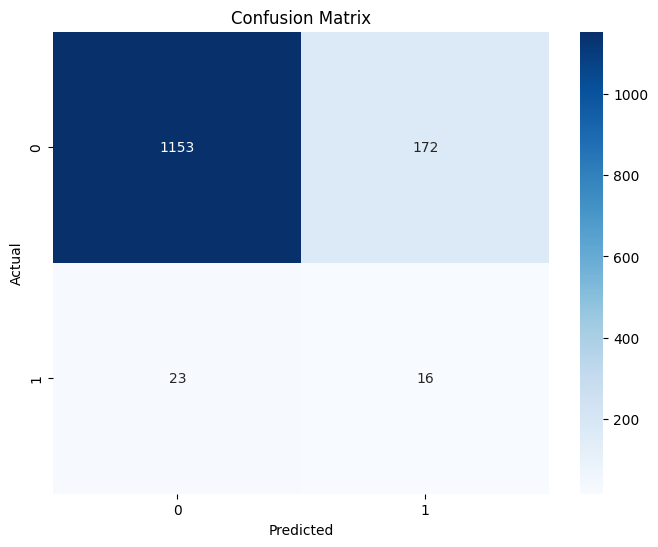

ROC AUC Score: 0.6402225447508465


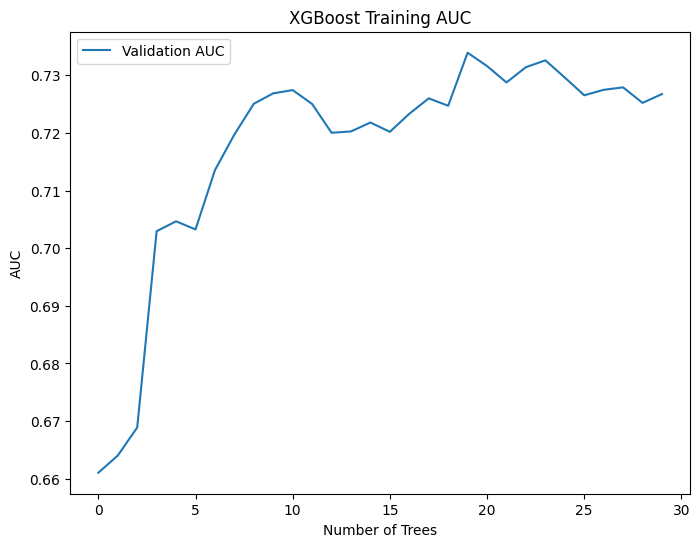

In [20]:
#Predict and evaluate the model
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

#Calculate and display accuracy
accuracy = accuracy_score(y_val, y_pred_adjusted)
print("Validation Accuracy:", accuracy)

#Classification report
report = classification_report(y_val, y_pred_adjusted)
print("Classification Report:\n", report)

#Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_adjusted)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_adjusted)
print("ROC AUC Score:", roc_auc)
plt.figure(figsize=(8, 6))
plt.plot(best_model.evals_result_['validation_0']['auc'], label='Validation AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.title('XGBoost Training AUC')
plt.legend()
plt.show()


**Improvements**


*   Increase ocerall accuracy and recall for class 0
*   precision fro class 1 has improved slightly.


